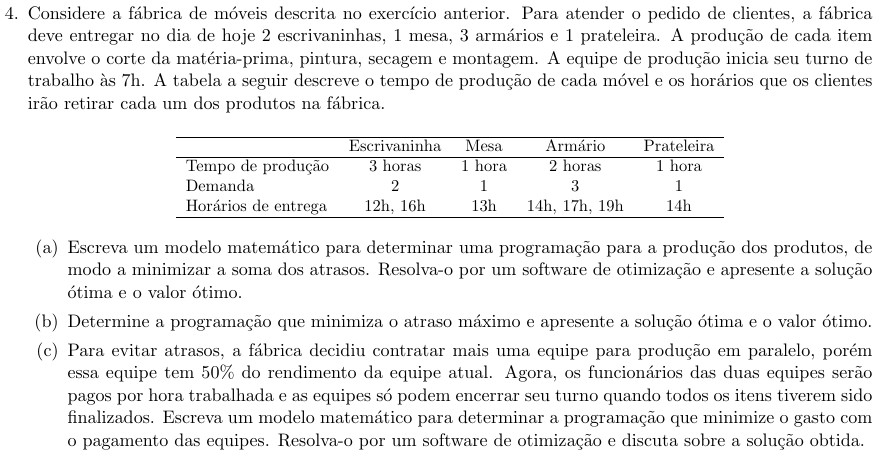

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/4.png')

In [2]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [3]:
# Dados
Moveis = [0, 'Escrivaninha 1', 'Escrivaninha 2', 'Mesa 1', 
          'Armário 1', 'Armário 2', 'Armário 3', 'Prateleira 1']
tempo_producao = {0: 0, 'Escrivaninha 1': 3, 'Escrivaninha 2': 3, 'Mesa 1': 1, 
                  'Armário 1': 2, 'Armário 2': 2, 'Armário 3': 2, 'Prateleira 1': 1}
horario_entrega = {0: 0, 'Escrivaninha 1': 12, 'Escrivaninha 2': 16, 'Mesa 1': 13, 
                   'Armário 1': 14, 'Armário 2': 17, 'Armário 3': 19, 'Prateleira 1': 14}
inicio = 7
R = 10**5

In [4]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.M = Set(initialize=Moveis)
M = model.M

# Parâmetros
model.p = Param(M, initialize=tempo_producao, within=NonNegativeReals)
model.h = Param(M, initialize=horario_entrega, within=NonNegativeReals)
model.I = Param(initialize=inicio, within=NonNegativeReals)
p, h, I = model.p, model.h, model.I

# Variáveis de decisão
model.x = Var(M * M, within=Binary)
model.C = Var(M, within=NonNegativeReals)
model.T = Var(M, within=NonNegativeReals)
x, C, T = model.x, model.C, model.T

# Função objetivo
model.obj = Objective(sense=minimize,
                      expr = sum(T[i] for i in M))

# Restrições
# Um sucessor por tarefa
model.r_sucessor = ConstraintList()
for i in M:
    model.r_sucessor.add(expr = sum(x[i, j] for j in M if j != i) == 1)
# Um antecessor por tarefa
model.r_antecessor = ConstraintList()
for j in M:
    model.r_antecessor.add(expr = sum(x[i, j] for i in M if i != j) == 1)
# Tempo de término
model.r_termino = ConstraintList()
model.r_termino.add(expr = C[0] == I)
for i in M:
    for j in M:
        if j != i and j != 0:
            model.r_termino.add(expr = C[j] >= C[i] + p[j] * x[i, j] + R * (x[i, j] - 1))
# Tempos de atraso positivos
model.r_atraso = ConstraintList()
for i in M:
    if i != 0:
        model.r_atraso.add(expr = T[i] >= C[i] - h[i])

# model.pprint()

In [5]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee=False)

In [6]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in M:
        for j in M:
            if i != j and value(x[i,j]) == 1:
                print('Móvel {} precede o {}.'.format(i, j))
    print()
    for i in M:
        print('Instante de conclusão do móvel {}: {:.2f} horas.'.format(i, value(C[i])))
    print()
    print('Mínima soma de atrasos resulta em {:.0f} horas'.format(value(model.obj)))
else:
    print(resultado.solver.termination_condition)

Móvel 0 precede o Armário 1.
Móvel Escrivaninha 1 precede o Mesa 1.
Móvel Escrivaninha 2 precede o 0.
Móvel Mesa 1 precede o Prateleira 1.
Móvel Armário 1 precede o Escrivaninha 1.
Móvel Armário 2 precede o Armário 3.
Móvel Armário 3 precede o Escrivaninha 2.
Móvel Prateleira 1 precede o Armário 2.

Instante de conclusão do móvel 0: 7.00 horas.
Instante de conclusão do móvel Escrivaninha 1: 12.00 horas.
Instante de conclusão do móvel Escrivaninha 2: 21.00 horas.
Instante de conclusão do móvel Mesa 1: 13.00 horas.
Instante de conclusão do móvel Armário 1: 9.00 horas.
Instante de conclusão do móvel Armário 2: 16.00 horas.
Instante de conclusão do móvel Armário 3: 18.00 horas.
Instante de conclusão do móvel Prateleira 1: 14.00 horas.

Mínima soma de atrasos resulta em 5 horas
